# 3. Light

## The Diffuse Reflection Equation

$$I_{P} = I_{A} + \sum_{i=1}^{n}I_{i}\frac{\left \langle \vec{N},\vec{L_{i}} \right \rangle}{\left | \vec{N} \right | \left | \vec{L_{i}} \right |}$$

cos a < 0 인 경우는 고려하지 않는다.

## Sphere Normals

![3_6.PNG](./3_6.PNG)

법선 벡터를 정하는 것은 복잡한 일이지만 우리는 구의 경우만을 고려할 것이기 때문에 어렵지 않게 법선 벡터를 정할 수 있다.

$$\vec{N} = \frac{P - C}{\left | P - C \right |}$$

## Rendering with Diffuse Reflection

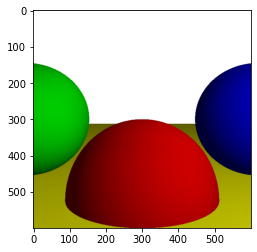

In [13]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

canvas_width = 600
canvas_height = 600

class Sphere:
    def __init__(self, center, radius, color):
        self.center = center
        self.radius = radius
        self.color = color
        
class Light:
    def __init__(self, ltype, intensity, position):
        self.ltype = ltype
        self.intensity = intensity
        self.position = position
        
AMBIENT = 0
POINT = 1
DIRECTIONAL = 2

viewport_size = 1
projection_plane_z = 1
camera_position = [0,0,0]
background_color = [255,255,255]

sphere1 = Sphere([0, -1, 3], 1, [255, 0, 0]) # OpenCv의 경우 RGB 가 아닌 BRG 순서이므로 순서를 조정했다.
sphere2 = Sphere([2, 0, 4], 1, [0, 0, 255])
sphere3 = Sphere([-2, 0, 4], 1, [0, 255, 0])
sphere4 = Sphere([0,-5001,0], 5000, [255, 255, 0])
spheres = [sphere1, sphere2, sphere3, sphere4]

light1 = Light(AMBIENT, 0.2, None)
light2 = Light(POINT, 0.6, [2,1,0])
light3 = Light(DIRECTIONAL, 0.2, [1,4,4])
lights = [light1, light2, light3]

def canvas2viewport(point2d):
    return [point2d[0] * viewport_size / canvas_width, point2d[1] * viewport_size / canvas_height, projection_plane_z]

def intersect_ray_sphere(origin, direction, sphere):
    oc = np.subtract(origin, sphere.center)
    
    k1 = np.dot(direction, direction)
    k2 = 2*np.dot(oc, direction)
    k3 = np.dot(oc, oc) - sphere.radius*sphere.radius
    
    discriminant = k2*k2 - 4*k1*k3
    if (discriminant < 0):
        return [math.inf, math.inf]
    
    t1 = (-k2 + math.sqrt(discriminant)) / (2*k1)
    t2 = (-k2 - math.sqrt(discriminant)) / (2*k1)
    return [t1, t2]

def compute_lighting(point, normal):
    intensity = 0
    length_n = np.linalg.norm(normal)
    
    for i in range(len(lights)):
        light = lights[i]
        if (light.ltype == AMBIENT):
            intensity += light.intensity
        else:
            vec_l = []
            if (light.ltype == POINT):
                vec_l = np.subtract(light.position, point)
            else: #DIRECTIONAL
                vec_l = light.position
            
            n_dot_l = np.dot(normal, vec_l)
            if (n_dot_l > 0):
                intensity += light.intensity * n_dot_l / (length_n * np.linalg.norm(vec_l))
    return intensity
        

def trace_ray(origin, direction, min_t, max_t):
    closest_t = math.inf
    closest_sphere = None
    
    for i in range(len(spheres)):
        ts = intersect_ray_sphere(origin, direction, spheres[i])
        if (ts[0] < closest_t and min_t < ts[0] and ts[0] < max_t):
            closest_t = ts[0]
            closest_sphere = spheres[i]
        if (ts[1] < closest_t and min_t < ts[1] and ts[1] < max_t):
            closest_t = ts[1]
            closest_sphere = spheres[i]
            
    if (closest_sphere == None):
        return background_color
    
    point = np.add(origin, np.dot(closest_t, direction))
    normal = np.subtract(point, closest_sphere.center)
    normal = np.dot(1.0 / np.linalg.norm(normal), normal)
    
    return np.dot(compute_lighting(point, normal), closest_sphere.color)

def put_pixel(x, y, color):
    x = canvas_width/2 + x
    y = canvas_height/2 - y
    if (x< 0 or x >= canvas_width or y < 0 or y >= canvas_height):
        return
    cv2.line(img, (int(x), int(y)), (int(x), int(y)), (color[0], color[1], color[2]))

x = -canvas_width/2
y = -canvas_height/2

img = np.zeros((canvas_width,canvas_height,3), dtype = np.uint8)

for i in range(canvas_width):
    for j in range(canvas_height):
        direction = canvas2viewport([x,y])
        color = trace_ray(camera_position, direction, 1, math.inf)
        put_pixel(x,y,color)
        y+=1
    y = -canvas_height/2
    x+=1
 

plt.imshow(img)
#cv2.imshow('Raytracer', img)
#cv2.waitKey()
#cv2.destoryAllWindows()

## Specular Reflection

유광 물체는 무광 물체와는 다른 방식으로 반사가 일어난다.

![3_8.PNG](./3_8.PNG)

무광 물체는 표면에서 난반사들이 일어나기 때문에 모든 방향으로 산란된 빛이 퍼지게 된다.

![image.png](./3_10.jpg)

반면 완벽한 유광인 거울의 경우 정반사가 일어난다.

![image-2.png](./3_11.jpg)

반사된 빛의 벡터를 R이라 할 때, R과 같은 방향이 많을 수록 더 많은 양의 빛이 반사된다.

![image-3.png](./3_12.jpg)

벡터 V를 view vector라 하자 이는 카메라를 가리키는 벡터이다. a를 R과 V 사이의 각이라 하면 a = 0 일때 모든 빛이 V 방향으로 반사되는 것이고 a = 90 이면 빛이 반사되지 않는 것이다.